# Superhero (and Supervillain) Name Generator

---

[Superhero Names Dataset](https://github.com/am1tyadav/superhero)

## Task 2

1. Import the data
2. Create a tokenizer
3. Char to index and Index to char dictionaries

In [1]:
!git clone https://github.com/am1tyadav/superhero

Cloning into 'superhero'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 8 (delta 0), reused 4 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (8/8), 47.08 KiB | 3.92 MiB/s, done.


In [2]:
with open('superhero/superheroes.txt', 'r') as f:
  data = f.read()

data[:100]



'jumpa\t\ndoctor fate\t\nstarlight\t\nisildur\t\nlasher\t\nvarvara\t\nthe target\t\naxel\t\nbattra\t\nchangeling\t\npyrrh'

In [4]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [5]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~',
    split='\n',
)

In [6]:
tokenizer.fit_on_texts(data)

In [7]:
char_to_index = tokenizer.word_index
index_to_char = dict((v, k) for k, v in char_to_index.items())

print(index_to_char)

{1: '\t', 2: 'a', 3: 'e', 4: 'r', 5: 'o', 6: 'n', 7: 'i', 8: ' ', 9: 't', 10: 's', 11: 'l', 12: 'm', 13: 'h', 14: 'd', 15: 'c', 16: 'u', 17: 'g', 18: 'k', 19: 'b', 20: 'p', 21: 'y', 22: 'w', 23: 'f', 24: 'v', 25: 'j', 26: 'z', 27: 'x', 28: 'q'}


## Task 3

1. Converting between names and sequences

In [8]:
names = data.splitlines()
names[:10]

['jumpa\t',
 'doctor fate\t',
 'starlight\t',
 'isildur\t',
 'lasher\t',
 'varvara\t',
 'the target\t',
 'axel\t',
 'battra\t',
 'changeling\t']

In [9]:
tokenizer.texts_to_sequences(names[0])

[[25], [16], [12], [20], [2], [1]]

In [10]:
def name_to_seq(name):
  return [tokenizer.texts_to_sequences(c)[0][0] for c in name]

In [11]:
name_to_seq(names[0])

[25, 16, 12, 20, 2, 1]

In [12]:
def seq_to_name(seq):
  return ''.join([index_to_char[i] for i in seq if i != 0])

In [13]:
seq_to_name(name_to_seq(names[0]))

'jumpa\t'

## Task 4

1. Creating sequences
2. Padding all sequences

In [14]:
sequences = []

for name in names:
  seq = name_to_seq(name)
  if len(seq) >= 2:
    sequences += [seq[:i] for i in range(2, len(seq) + 1)]

In [15]:
sequences[:10]

[[25, 16],
 [25, 16, 12],
 [25, 16, 12, 20],
 [25, 16, 12, 20, 2],
 [25, 16, 12, 20, 2, 1],
 [14, 5],
 [14, 5, 15],
 [14, 5, 15, 9],
 [14, 5, 15, 9, 5],
 [14, 5, 15, 9, 5, 4]]

In [16]:
max_len = max([len(x) for x in sequences])
print(max_len)

33


In [17]:
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(
    sequences, padding='pre', maxlen=max_len
)

print(padded_sequences[0])

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0 25 16]


In [18]:
padded_sequences.shape

(88279, 33)

## Task 5: Creating Training and Validation Sets

1. Creating training and validation sets

In [19]:
x, y = padded_sequences[:, :-1], padded_sequences[:, -1]
print(x.shape, y.shape)

(88279, 32) (88279,)


In [20]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(66209, 32) (66209,)
(22070, 32) (22070,)


In [21]:
num_chars = len(char_to_index.keys()) + 1
print(num_chars)

29


## Task 6: Creating the Model

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPool1D, LSTM, Bidirectional, Dense
from tensorflow.keras.layers import Dense, Bidirectional

model = Sequential([
                    Embedding(num_chars, 8, input_length=max_len - 1),
                    Conv1D(64, 5, strides=1, activation='tanh', padding='causal'),
                    MaxPool1D(2),
                    LSTM(32),
                    Dense(num_chars, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.build(input_shape=(None, max_len-1))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 32, 8)               │             232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 32, 64)              │           2,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 16, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 29)                  │             957 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,229 (63.39 KB)

 Trainable params: 16,229 (63.39 KB)

 Non-trainable params: 0 (0.00 B)

## Task 7: Training the Model

In [25]:
h = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50, verbose=2,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
    ]
)

Epoch 1/50
2070/2070 - 29s - 14ms/step - accuracy: 0.1946 - loss: 2.7309 - val_accuracy: 0.2304 - val_loss: 2.5883
Epoch 2/50
2070/2070 - 43s - 21ms/step - accuracy: 0.2363 - loss: 2.5382 - val_accuracy: 0.2396 - val_loss: 2.5031
Epoch 3/50
2070/2070 - 40s - 19ms/step - accuracy: 0.2505 - loss: 2.4676 - val_accuracy: 0.2645 - val_loss: 2.4408
Epoch 4/50
2070/2070 - 39s - 19ms/step - accuracy: 0.2649 - loss: 2.4168 - val_accuracy: 0.2723 - val_loss: 2.4046
Epoch 5/50
2070/2070 - 42s - 20ms/step - accuracy: 0.2754 - loss: 2.3800 - val_accuracy: 0.2748 - val_loss: 2.3815
Epoch 6/50
2070/2070 - 40s - 19ms/step - accuracy: 0.2847 - loss: 2.3492 - val_accuracy: 0.2864 - val_loss: 2.3592
Epoch 7/50
2070/2070 - 43s - 21ms/step - accuracy: 0.2947 - loss: 2.3230 - val_accuracy: 0.2912 - val_loss: 2.3346
Epoch 8/50
2070/2070 - 42s - 20ms/step - accuracy: 0.3024 - loss: 2.2990 - val_accuracy: 0.3009 - val_loss: 2.3180
Epoch 9/50
2070/2070 - 38s - 19ms/step - accuracy: 0.3114 - loss: 2.2774 - val_a

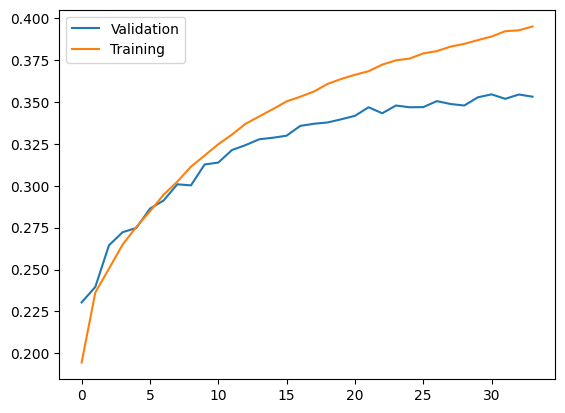

In [27]:
from matplotlib import pyplot as plt
epochs_ran = len(h.history['loss'])
plt.plot(range(0, epochs_ran), h.history['val_accuracy'], label='Validation')
plt.plot(range(0, epochs_ran), h.history['accuracy'], label='Training')
plt.legend()
plt.show()


## Task 8: Generate Names!

In [29]:
def generate_names(seed):
  for i in range(0, 40):
    seq = name_to_seq(seed)
    padded = tf.keras.preprocessing.sequence.pad_sequences([seq], padding='pre', maxlen=max_len-1, truncating='pre')
    pred = model.predict(padded)[0]
    pred_char = index_to_char[tf.argmax(pred).numpy()]
    seed += pred_char

    if pred_char == '\t':
      break
  print(seed)

In [34]:
generate_names('x')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
xeno bord	
